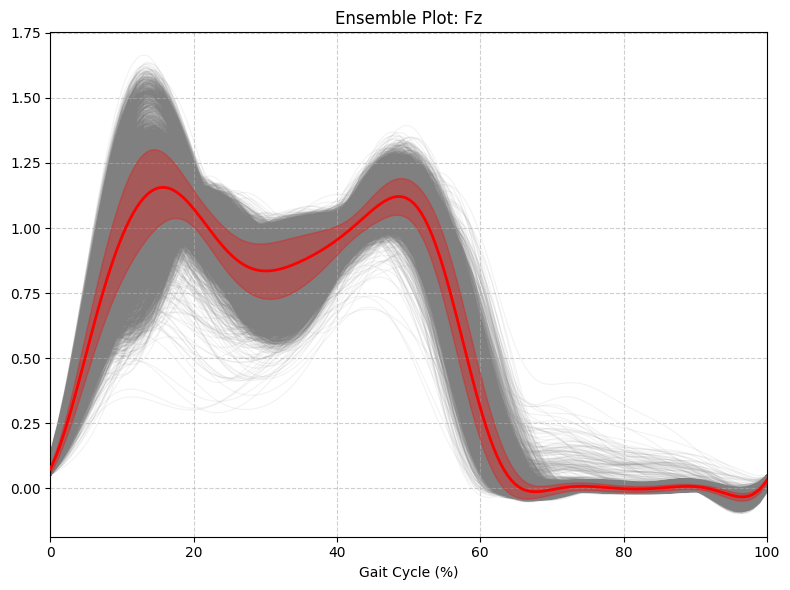

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_ensemble_stats(data, ax, title, color='red'):
    """
    グレイで重ね書き + 平均(赤) + 標準偏差(赤帯) のプロット関数
    
    Parameters:
        data: shape (n_strides, n_timepoints) の2次元配列
        ax: matplotlib の axes オブジェクト
        title: グラフのタイトル
        color: 平均線とSD帯の色
    """
    n_strides, n_points = data.shape
    x = np.linspace(0, 100, n_points)
    
    # 1. グレイで全ストライドを重ね書き
    # alpha=0.1 程度にすると重なり具合が見やすくなります
    for i in range(n_strides):
        ax.plot(x, data[i], color='gray', alpha=0.1, linewidth=0.8, zorder=1)
        
    # 統計量の計算
    mean_curve = np.mean(data, axis=0)
    std_curve = np.std(data, axis=0)
    
    # 2. 標準偏差を色付きで塗りつぶし (Mean ± 1SD)
    ax.fill_between(x, 
                    mean_curve - std_curve, 
                    mean_curve + std_curve, 
                    color=color, alpha=0.3, zorder=2, label='Mean ± 1SD')

    # 3. 平均を実線でプロット
    ax.plot(x, mean_curve, color=color, linewidth=2, zorder=3, label='Mean')
    
    # レイアウト設定
    ax.set_title(title)
    ax.set_xlabel('Gait Cycle (%)')
    ax.set_xlim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.6)

# --- 使用例 ---

# 1. データの読み込み (適宜パスを変更してください)
file_path = 'processed_data/all_data_combined.npz'  # 例
loaded_data = np.load(file_path)

ensemble = loaded_data['ensemble']  # shape: (N, 200, 26)
columns = loaded_data['columns']    # カラム名リスト

# 2. プロットしたいカラムを指定（例: 'Fz', 'Knee_ZX' など）
target_column = 'Fz'  # ※保存時にRight/Leftが統合され 'Fz' になっている場合は 'Fz' を指定

# カラム名からインデックスを取得
try:
    # 統合データで 'Fz' のようになっている場合
    if target_column in columns:
        col_idx = list(columns).index(target_column)
    else:
        # もし元のカラム名がわからなければ一覧を表示
        print(f"Available columns: {columns}")
        col_idx = 25 # Fzのインデックス (例)
        
    # 該当データの抽出 (全ストライド, 全時刻, 指定カラム)
    data_to_plot = ensemble[:, :, col_idx]

    # 3. 描画
    fig, ax = plt.subplots(figsize=(8, 6))
    
    plot_ensemble_stats(
        data_to_plot, 
        ax, 
        title=f"Ensemble Plot: {columns[col_idx]}", 
        color='red'
    )
    
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{columns[col_idx]}_ensemble.png") # 保存する場合

except Exception as e:
    print(f"Error: {e}")

Plotting 26 columns...


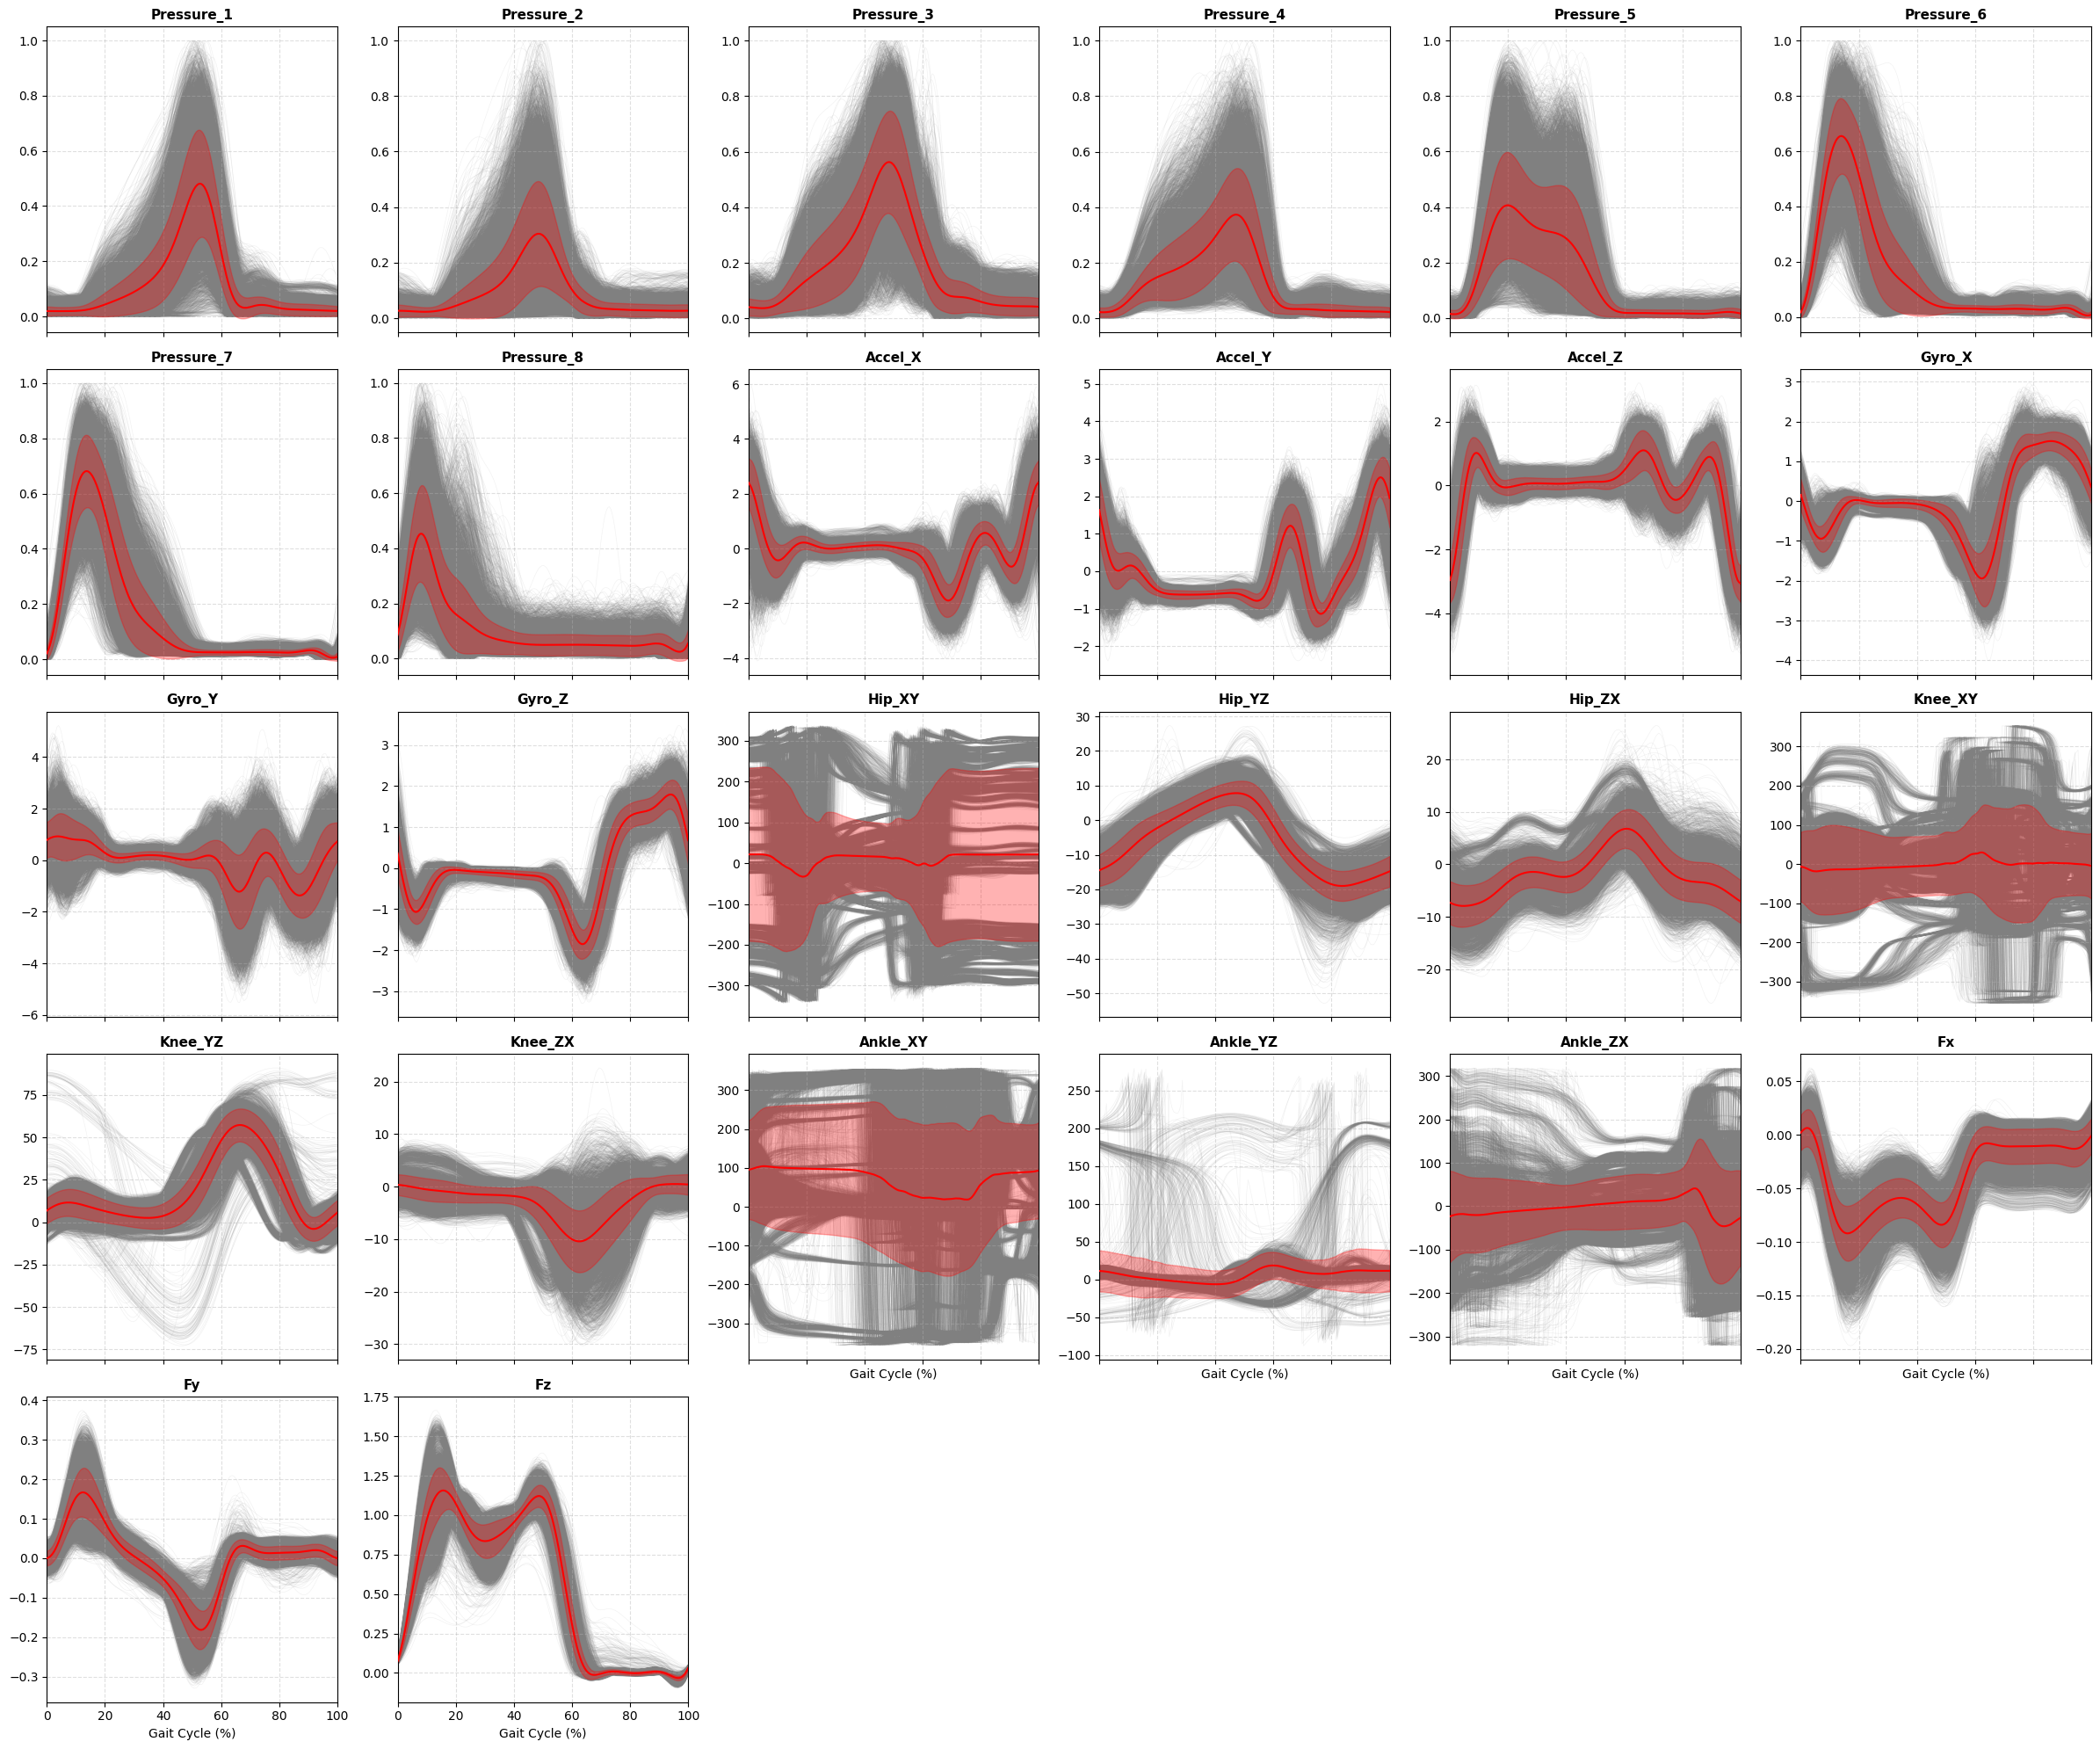

In [3]:
import math

def plot_all_columns(data, column_names, output_filename='all_columns_ensemble.png'):
    """
    全カラムのアンサンブルプロット（スパゲッティ+平均+SD）を描画して保存する関数
    
    Parameters:
        data: shape (ストライド数, 200, カラム数) の3次元配列
        column_names: カラム名のリスト (長さは data.shape[2] と一致すること)
        output_filename: 保存するファイル名
    """
    n_cols_data = data.shape[2]
    n_frames = data.shape[1]
    
    # --- グリッドレイアウトの計算 ---
    # 横6列で固定し，行数を自動計算
    n_cols_subplot = 6
    n_rows = math.ceil(n_cols_data / n_cols_subplot)
    
    # 図全体のサイズ設定 (横幅広め，縦は行数に応じて)
    fig, axes = plt.subplots(n_rows, n_cols_subplot, figsize=(24, 4 * n_rows), sharex=True)
    axes = axes.flatten()  # axの配列を1次元化してループしやすくする
    
    x = np.linspace(0, 100, n_frames)
    
    print(f"Plotting {n_cols_data} columns...")
    
    # --- 各カラムのプロットループ ---
    for idx, ax in enumerate(axes):
        if idx < n_cols_data:
            col_name = column_names[idx]
            col_data = data[:, :, idx]  # (ストライド数, 200)
            
            # 1. 個別ストライドの描画 (グレー)
            # データ量が多い場合は alpha をさらに下げる (0.05など) と良いです
            for stride_i in range(col_data.shape[0]):
                ax.plot(x, col_data[stride_i], color='gray', alpha=0.1, linewidth=0.5, zorder=1)
            
            # 統計量の計算
            mean_curve = np.mean(col_data, axis=0)
            std_curve = np.std(col_data, axis=0)
            
            # 2. 標準偏差の帯 (赤色半透明)
            ax.fill_between(x, 
                            mean_curve - std_curve, 
                            mean_curve + std_curve, 
                            color='red', alpha=0.3, zorder=2)
            
            # 3. 平均値の線 (赤色実線)
            ax.plot(x, mean_curve, color='red', linewidth=1.5, zorder=3)
            
            # サブプロットの装飾
            ax.set_title(col_name, fontsize=11, fontweight='bold')
            ax.grid(True, linestyle='--', alpha=0.4)
            ax.set_xlim(0, 100)
            
            # 一番下の行だけX軸ラベルを表示
            if idx >= n_cols_data - n_cols_subplot:
                ax.set_xlabel('Gait Cycle (%)')
        else:
            # データがない余ったサブプロットは非表示にする
            ax.axis('off')
            
    plt.tight_layout()
    # plt.savefig(output_filename, dpi=150)
    # print(f"Saved plot to {output_filename}")
    plt.show()

# --- 実行例 ---
if __name__ == "__main__":
    # 1. データの読み込み
    # ファイルパスは実際のファイルに合わせて変更してください
    file_path = 'processed_data/all_data_combined.npz'
    
    if os.path.exists(file_path):
        loaded_data = np.load(file_path)
        ensemble = loaded_data['ensemble']  # shape: (N, 200, 26)
        columns = loaded_data['columns']    # カラム名リスト
        
        # 2. プロット関数の呼び出し
        plot_all_columns(ensemble, columns)
    else:
        print(f"File not found: {file_path}")
        print("Please set the correct file path.")